In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from skimage.feature import hog as dtb
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [3]:
source = "/content/drive/MyDrive/Colab Notebooks/Traffic Signs Detection and Classification/gtsrb-german-traffic-sign/"

In [4]:
train_meta = pd.read_csv(source + "Train.csv")

In [5]:
test_meta = train_meta = pd.read_csv(source + "Test.csv")

In [6]:
red_hue = np.zeros(256)
for i in range(14):
  red_hue[i] = 255 - i*18
for i in range(36):
  red_hue[220+i] = i*7

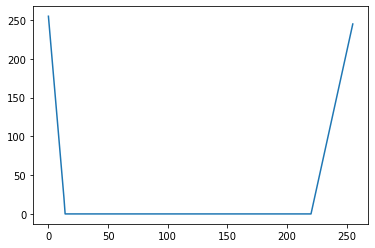

In [7]:
plt.plot(red_hue)

In [8]:
red_sat = np.arange(256)
red_sat[175:] = 255

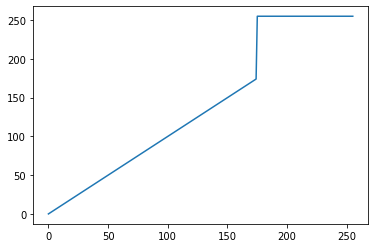

In [9]:
plt.plot(red_sat)

In [10]:
blue_hue = np.zeros(256)
for i in range(12):
  blue_hue[130+i] = i*21
blue_hue[142:151] = 255
for i in range(25):
  blue_hue[151+i] = 255-i*10

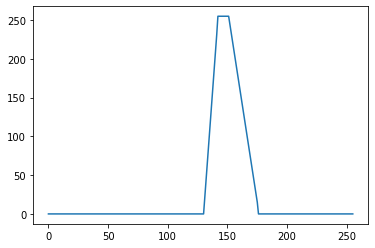

In [11]:
plt.plot(blue_hue)

In [12]:
blue_sat = np.zeros(256)
blue_sat[0:50] = 20
for i in range(50):
  blue_sat[50+i] = i*1.6 +20
blue_sat[100:240] = 255
for i in range(16):
  blue_sat[240+i] = 255-i*14

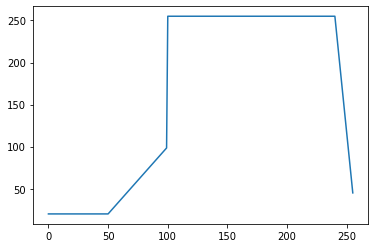

In [13]:
plt.plot(blue_sat)

In [14]:
yel_hue = np.zeros(256)
for i in range(10):
  yel_hue[25+i] = i*25
yel_hue[34:39] = 255
for i in range(12):
  yel_hue[39+i] = 255-i*21

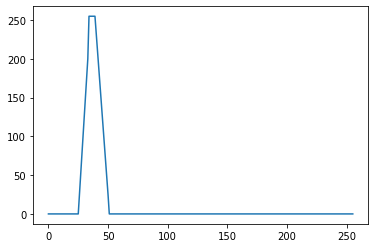

In [15]:
plt.plot(yel_hue)

In [16]:
yel_sat = np.zeros(256)
for i in range(90):
  yel_sat[75+i] = i*1.4 +100
yel_sat[165:256] = 255

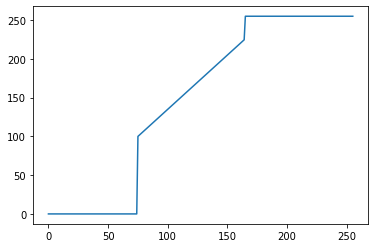

In [17]:
plt.plot(yel_sat)

In [18]:
def Min_Max_Scaler(arr):
  max = arr.max()
  min = arr.min()
  arr = (arr-min)/(max-min)
  return arr

In [43]:
def Main(meta):
  Features=[]
  Labels=[]
  for i in tqdm(range(len(meta['Path']))):
    try:
      image = plt.imread(source + meta['Path'][i])
      hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HLS_FULL)
      dim=(200,200)
      resized = cv2.resize(hsv ,dim, interpolation = cv2.INTER_AREA)
      resized[:,:,0] = Min_Max_Scaler(resized[:,:,0])*255
      resized[:,:,1] = Min_Max_Scaler(resized[:,:,1])*255
      scaled = np.array(resized, dtype='uint8')
      red_lut_hue = red_hue[scaled[:,:,0]]
      red_lut_sat = red_sat[scaled[:,:,1]]
      blue_lut_hue = blue_hue[scaled[:,:,0]]
      blue_lut_sat = blue_sat[scaled[:,:,1]]
      yel_lut_hue = yel_hue[scaled[:,:,0]]
      yel_lut_sat = yel_sat[scaled[:,:,1]]
      mask_sat = red_lut_sat + blue_lut_sat + yel_lut_sat
      mask_hue = red_lut_hue + blue_lut_hue + yel_lut_hue
      test_hue = Min_Max_Scaler(mask_hue)*127
      test_sat = Min_Max_Scaler(mask_sat)*127
      mask=test_hue+test_sat
      kernel = np.ones((7,7),np.uint8)
      erosion = cv2.erode(mask,kernel,iterations = 3)
      cent , _ = cv2.findContours(erosion.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      areas = [cv2.contourArea(c) for c in cent]
      max_index = np.argmax(areas)
      area=areas[max_index]
      x,y,w,h = cv2.boundingRect(cent[max_index])
      croped=resized[y:y+w,x:x+w]
      croped = cv2.cvtColor(croped, cv2.COLOR_HSV2BGR)
      croped = cv2.resize(croped,(80,80))
      gray = cv2.cvtColor(croped, cv2.COLOR_BGR2GRAY)
      gray = Min_Max_Scaler(gray)*255
      gray = gray.astype('uint8')
      th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,5)
      descriptor = dtb(th, orientations=8,pixels_per_cell=(4,4))
      Features.append(descriptor)
      Labels.append(meta['ClassId'][i])
    except Exception as e: 
      print(e)
  Features=np.array(Features)
  Labels=np.array(Labels)
  pca = PCA(n_components = 50)
  X = pca.fit_transform(Features)
  return X, Labels

In [74]:
X_train, Y_train = Main(train_meta)

  0%|          | 53/12630 [00:00<03:20, 62.82it/s]

read past end of file


  2%|▏         | 230/12630 [00:03<02:59, 69.05it/s]

read past end of file


100%|██████████| 12630/12630 [03:25<00:00, 61.56it/s]


In [75]:
X_test, Y_test = Main(test_meta)

  0%|          | 53/12630 [00:00<03:05, 67.63it/s]

read past end of file


  2%|▏         | 230/12630 [00:03<03:19, 62.28it/s]

read past end of file


100%|██████████| 12630/12630 [03:22<00:00, 62.45it/s]


In [76]:
classifier=SVC(kernel='linear',gamma='scale')
classifier.fit(X_train,Y_train)

SVC(kernel='linear')

In [80]:
print ('SVM Mean Accuracy of Training dataset: ',classifier.score(X_train,Y_train))
print ('SVM Mean Accuracy of Test dataset: ',classifier.score(X_test,Y_test))

SVM Mean Accuracy of Training dataset:  0.7023281596452328
SVM Mean Accuracy of Test dataset:  0.7017738359201774


In [82]:
import pickle

with open('SVM.pickle', 'wb') as f:
    pickle.dump(classifier, f)